# Assignment 2
Some general remarks for handing in exercises:
- Each exercise comes with context and code from the exercise-set of which it is a part. It is up to you to recycle the right code. Run all the code (make sure the output is present and correct as far as you can tell) and then save and submit.  Submitting code without running it runs the risk of not getting credit.
- Make sure to answer each sub-exercise
- Commenting amply on your results makes it easier to understand that you were on the right track, even if the answer was incorrect (or partially correct)

### Week 4

> **Ex. 4.3.1**: Investigate how well your model generalizes. You may have noticed that the performance seemed a little too good to be true in Ex 4.2.1.
1. Why did you get such a high accuracy in the previous exercise?
2. Split your data into a test and training set of equal size. Train the model only on the training set and report its accuracy and F1 score (for minority class) on both the training and test sets.
3. Comment on the difference you observe.
>
> *Hint: Watch out for unbalanced class proportions! You may want to randomly reorder the rows of your datapoints and target labels so your training and test sets have the same amount of heroes and villains.*

>**Ex. 4.4.1**: Let's put our classifier to use!
* Retrain your model on all of your data (still only heroes and villains).
* Get a team alliance representation of the ambiguous characters
* Use the model the estimate the probability that each character is a villain (let's call this *villainness*). You can use the `.predict_proba` method on the model to get probability estimates rather than class assignments. It produces an array with two columns, where the 1st column is the probability of class 1 (which is heroes).
* **Visualize the "heroness" distribution for all ambiguous characters**. Comment on the result.

### Week 5
You should have a dataframe called `data_teams` with characters as rows and alliances as columns (+ one column for faction)

>**Ex. 5.1.2**: Split your data (`data_teams`) into two subsets. One where characters are affiliated with X-men and one where they are not.
1. What is the entropy of target labels in each subset?
2. What is the weighted average entropy of the split?
3. Write a function that computes the weighted average entropy of a split, given the data and team (name or id) on which to split the data. Show that it gives you the same split entropy that you obtained in point 2.
4. Plot the distribution of split entropy for all features. Comment on the result. My figure looks [like this](https://dhsvendsen.github.io/images/BD_5_1_2_4.png).

>**Ex. 5.2.2**: *Fit* a logistic regression! You can use the `scipy` module `scipy.optimize.curve_fit`
to fit a model to some data (i.e. find the best parameter values `w`). 
> Fit the `logistic_regression` to the data `x` (input) and `y` (target).
> Again, plot and color the points according to their prediction. My figure looks like [this](https://dhsvendsen.github.io/images/BD_5_2_2_b.png). Comment on the figure and on the shape of the decision boundary.

### Week 6

> **Ex. 6.1.3**: Another very famous type of synthetic network is the Barabási–Albert (BA) network.
1. Describe what a BA network is and how to create one.
2. On the [`NetworkX` documentations site](https://networkx.github.io/documentation/networkx-2.2/reference/generators.html), find a method you can use for generating a BA network. Create one with $N=100$ nodes and number of new edges from each new node $m=2$.
3. Plot the network
4. Visualize the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) of your newly created BA graph.
5. Explain the main difference(s) you observe, when comparing to the ER network.

> **Ex: 6.2.2**: Create a `networkx.Graph` that represents each partnership between characters, as an edge. Print the number of nodes, edges and average degree of the resulting network.
**Do not** add characters that have no partners. And **do not** add links to partners of characters that are not in
your dataset.
>
> *Hint 1: You don't have to explicitly add nodes. Adding an edge will automatically add the corresponding nodes*<br>
> *Hint 2: As you know, many of the characters have a parenthesis in their name that is not important (like "Loki
(comics)"). If you remove this parenthesis your plots in the following will look much nicer. E.g. the regex code
`re.sub(" \(.+?\)", "", char)` will do the job of cleaning up a name like "Loki (comics)" for you. But then there's characters like "Captain America (William Burnside)"
where you might want to keep the parenthesis. It's not a hard requirement that you handle this in an elegant way,
just a suggestion for improving your analysis. In any event, ARGUE for what you do, even if that's doing nothing.*

In [35]:
import re, os

def get_partners(char, faction=None):
    """Return list of alliances for Marvel character."""
    if faction is None:
        for faction in ["heroes", "ambiguous", "villains"]:
            faction_chars = [c[:-4] for c in os.listdir("../data/%s" % faction)]
            if char in faction_chars:
                break
    # Load character markup
    with open("../data/%s/%s.txt" % (faction, char)) as fp:
        markup = fp.read()
        
    # Get partners field
    partners_field = re.findall(r"\| *partners[\w\W]+?(?=\|.+=|\}\})", markup)
    if partners_field == []:
        return []
 
    # Extract links from partners field
    return [t[2:-1] for t in re.findall(r"\[\[.+?[\]\|]", partners_field[0])]

get_partners("Iron Man (Ultimate Marvel character)")

['Ultimate Captain America', 'Ultimate Thor', 'War Machine']


nodes:           81
edges:           64
average degree:  1.5802469135802468



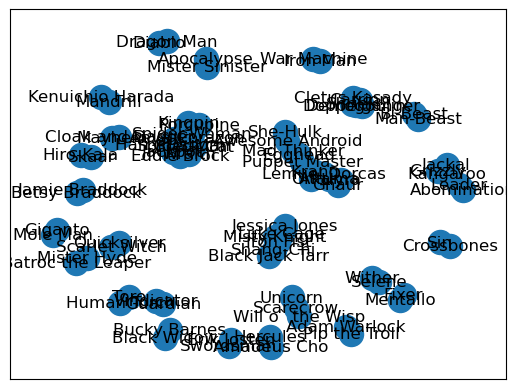

In [81]:
import networkx as nx
import pandas as pd
from numpy import average
G = nx.empty_graph()
#df = pd.read_csv('../outputs/marvel_characters.csv')

def clean_name(char):
    return re.sub(r" \(.+\)", "", char)

#make a set of every character
char_set = set()
for faction in ["heroes", "ambiguous", "villains"]:
    for char in os.listdir("../data/%s" % faction):
        if get_partners(char[:-4]): # only characters with partners get included in char_set
            char_set.add(char[:-4])
        
        
for char in char_set: # check that the character has partners (isn't lonely)
    for partner in get_partners(char): # check that the character's partners are in our dataset
        if partner in char_set:
            G.add_edge(clean_name(char), clean_name(partner))
    
nx.draw_networkx(G)
degs = [node[1] for node in G.degree()]
avg_deg = average(degs)
msg = f"""
nodes:           {len(G.nodes)}
edges:           {G.size()}
average degree:  {avg_deg}
"""
print(msg)

> **Ex: 6.2.3**: Plot the degree distribution of your character network. What type of random network (synthetic network) does it resemble?

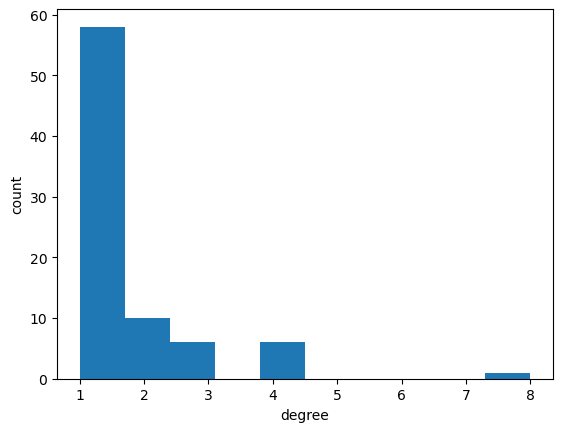

In [87]:
from matplotlib import pyplot as plt
plt.hist(degs)
plt.xlabel("degree")
plt.ylabel("count")
plt.show()

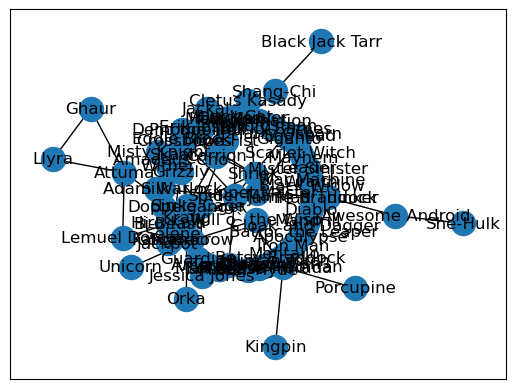

In [105]:
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, layout)

The above graph resembles a 